# 6.6 Sourcing & Analyzing Federal Debt Time-Series Data

## 1. Import Data Libraries
## 2. Subsetting, wrangling, and cleaning time-series data
## 3. Decompose the data's components
## 4. Testing for Stationarity Using the Dickey-Fuller test
## 5. Stationarizing the Federal Debt Data - First Round of Differencing
## 6. Second Round of Differencing
## 7. Bonus Task

## 1. Import Data Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'z9KJune_pJ8RzrhweZgR'

In [3]:
data = quandl.get('FRED/GFDEBTN')

In [4]:
data.head(5)

,Value
Date,
1966-01-01,320999.0
1966-04-01,316097.0
1966-07-01,324748.0
1966-10-01,329319.0
1967-01-01,330947.0


In [5]:
data.shape

(224, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

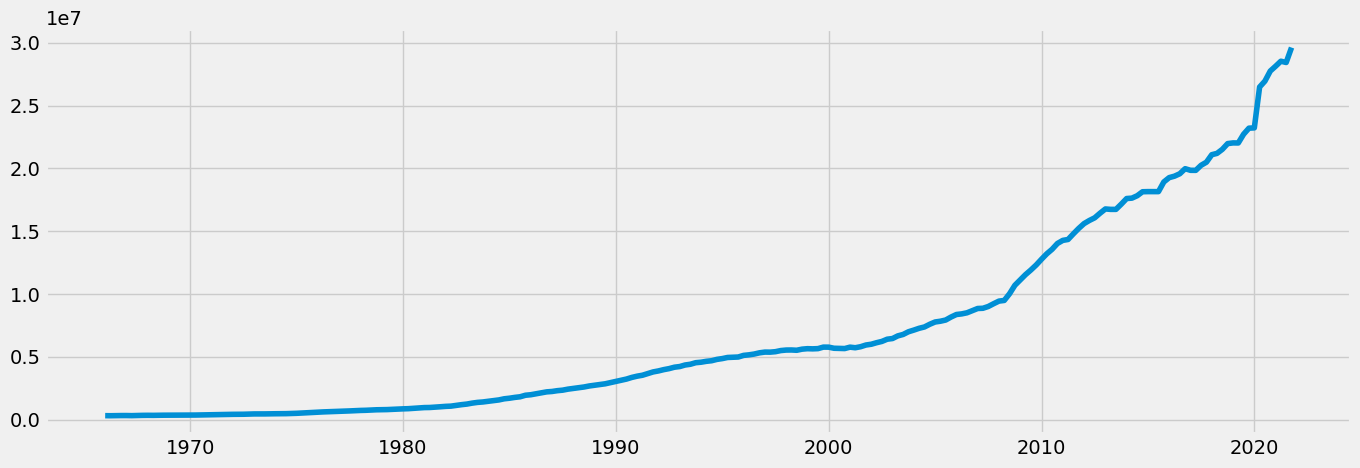

In [8]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

## 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [10]:
#create subset for dates between 
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-01-01')]

### I chose the date range 1/1/80-1/1/20 because the federal debt before the 80s were much different and 2020 had covid-19 were the was a huge national debt increase due to high unemployement and people accruing a lot of debt.

In [11]:
data_sub.shape

(160, 2)

In [12]:
data_sub.head()

,Date,Value
56,1980-01-01,863451.0
57,1980-04-01,877614.0
58,1980-07-01,907701.0
59,1980-10-01,930210.0
60,1981-01-01,964531.0


In [13]:
# Set the "Date" column as the index
from datetime import datetime
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
1980-01-01,863451.0
1980-04-01,877614.0
1980-07-01,907701.0
1980-10-01,930210.0
1981-01-01,964531.0


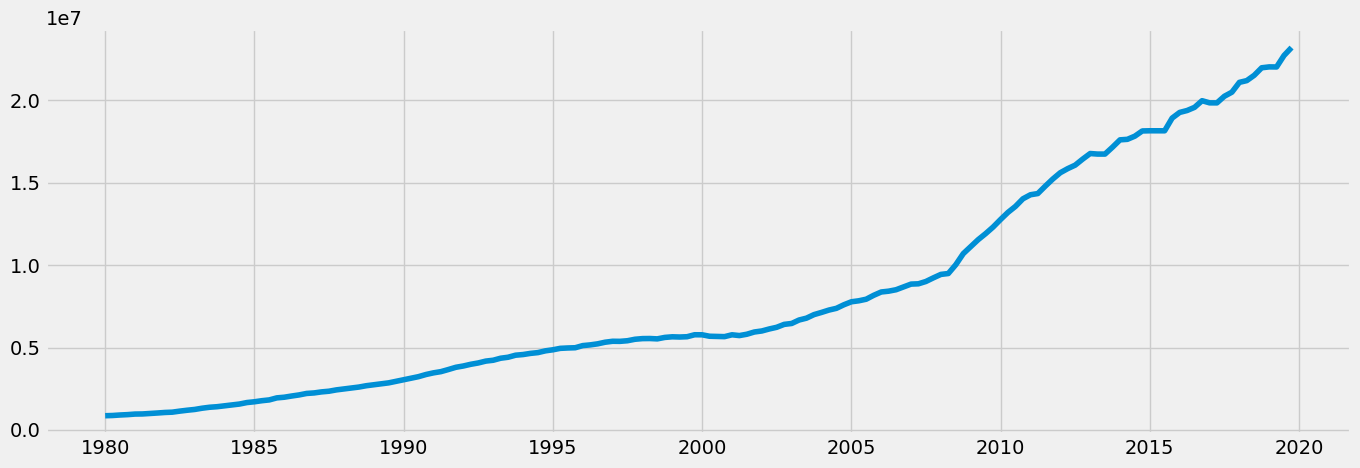

In [14]:
# Plot the new data set in line chart

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [15]:
# Check for missing values 
data_sub.isnull().sum() 

Value    0
dtype: int64

In [16]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

## 3. Decompose the data's components

In [17]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
# Define a fixed size for all special charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

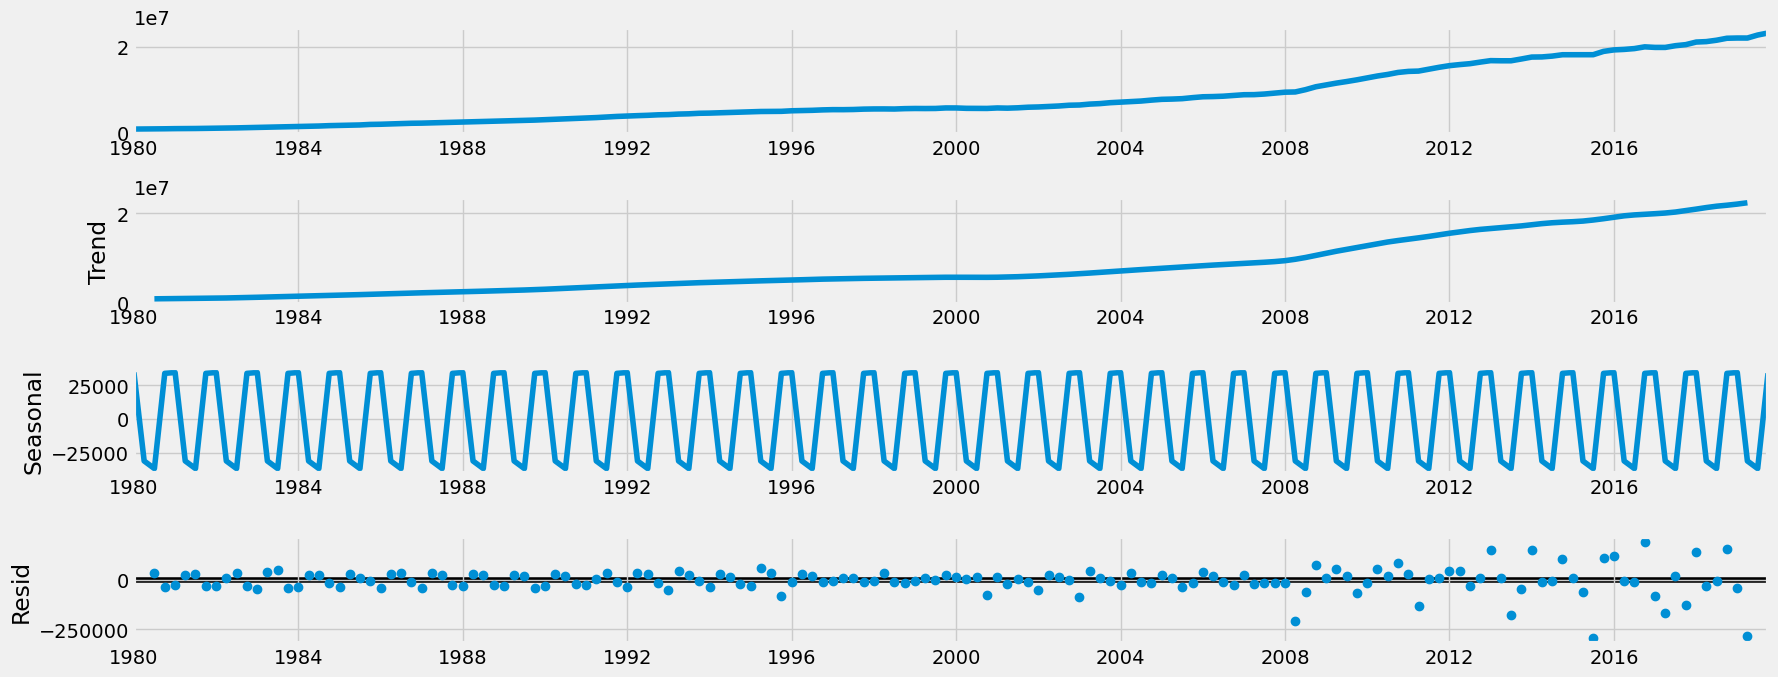

In [19]:
# Plot the separate components
decomposition.plot()
plt.show()

### There is an upward linear trend of national debt after 2009 which is similar to the level since this data did not need smoothing. The decomposition shows this data has seasonality where the spike curves regularly. The residual chart shows the noise of the data, where the plots are fairly close to around zero meaning that there is not much unexplained noise in this data. 

## 4. Testing for Stationarity Using the Dickey-Fuller test

In [20]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

# Define the function
def dickey_fuller(timeseries):
   
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)
    
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.297749
p-value                          0.998954
Number of Lags Used             13.000000
Number of Observations Used    146.000000
Critical Value (1%)             -3.475953
Critical Value (5%)             -2.881548
Critical Value (10%)            -2.577439
dtype: float64


### The test statistic is much larger than the critical value (5%) so we need to stationize the data

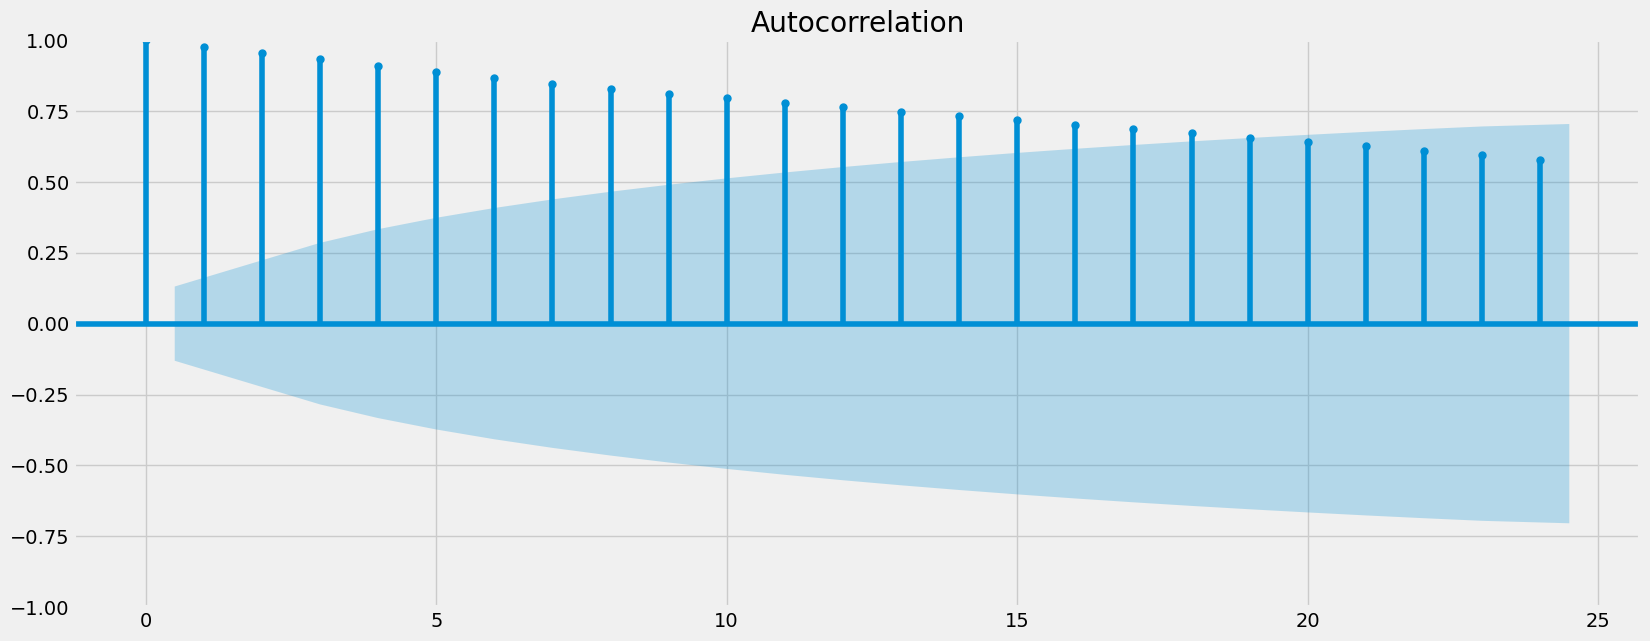

In [21]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data)
plt.show()

## 5. Stationarizing the Federal Debt Data - Round of Differencing

In [22]:
data_diff = data_sub - data_sub.shift(1) 

In [23]:
# Remove missing values that come as a result of differencing
data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,Value
datetime,
1980-04-01,14163.0
1980-07-01,30087.0
1980-10-01,22509.0
1981-01-01,34321.0
1981-04-01,6643.0


In [25]:
data_diff.columns

Index(['Value'], dtype='object')

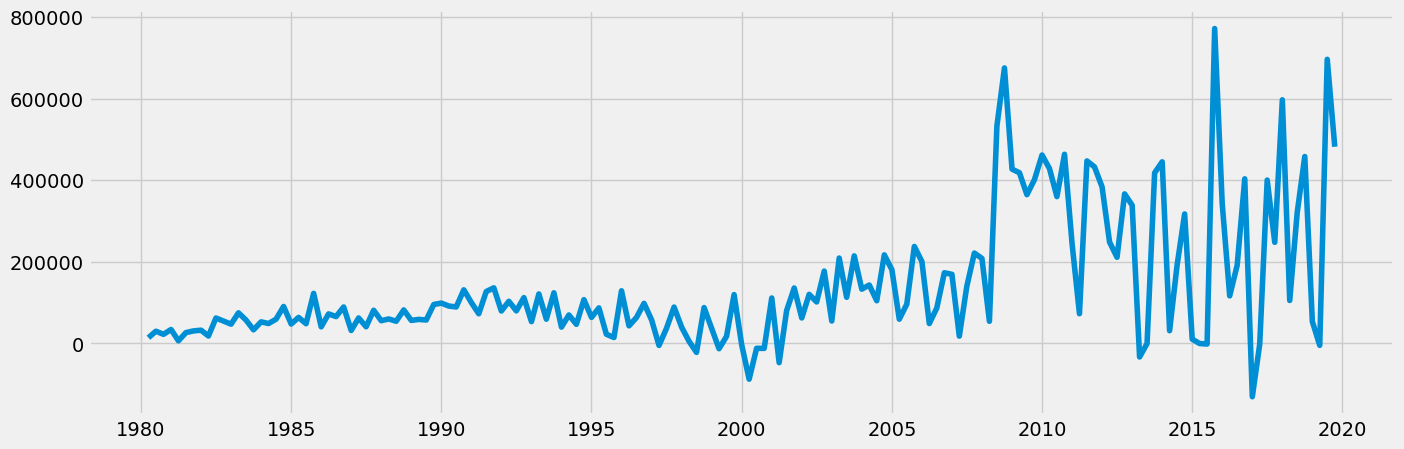

In [26]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
#Re-run Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.390447
p-value                          0.586847
Number of Lags Used             10.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


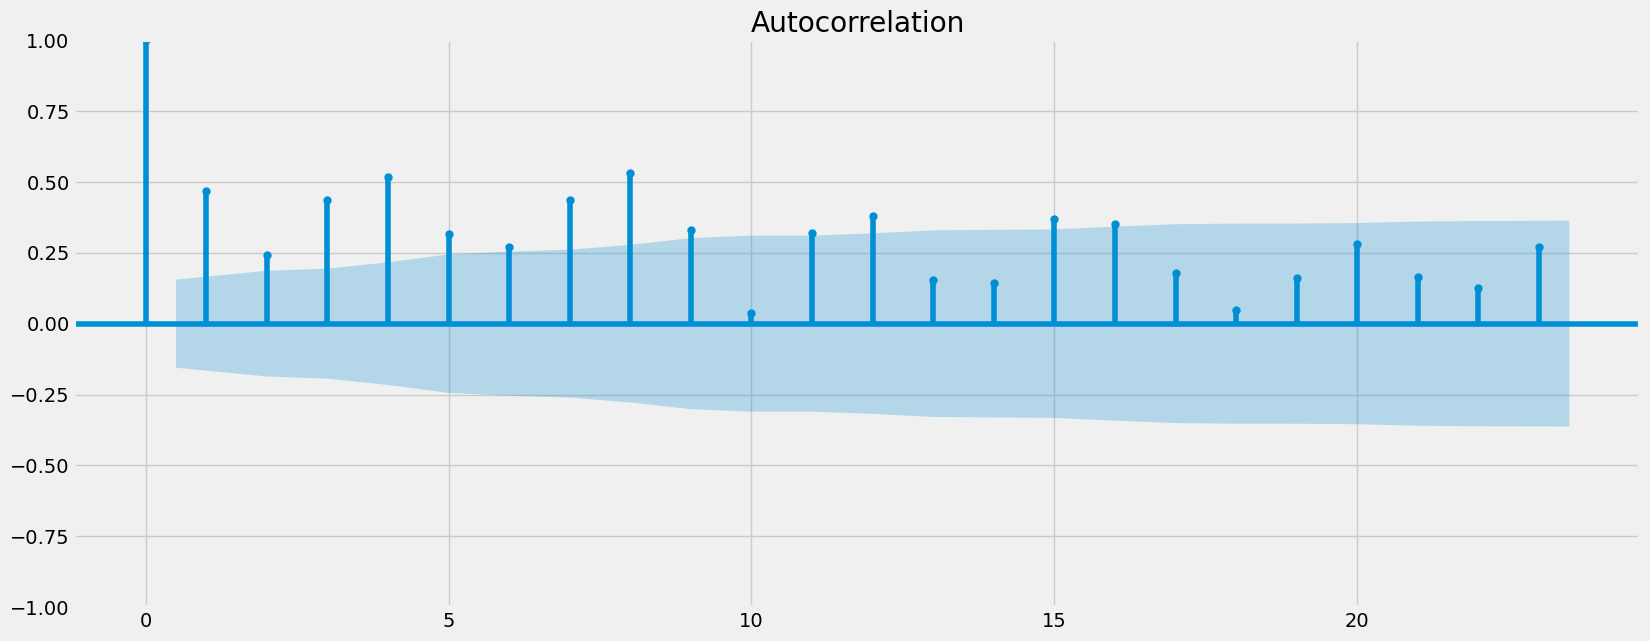

In [28]:
# Check out a plot of autocorrelations
plot_acf(data_diff)
plt.show()

### Observations: The test statistic is still larger at -1.39 than the critical value (5%) which is -2.88. This means this dataset is still not stationary so we will need to do another round of differencing. 

## 6. Second Round of Differencing

In [29]:
data_diff2 = data_diff - data_diff.shift(1) 

In [30]:
# Remove missing values that come as a result of differencing
data_diff2.dropna(inplace = True)

In [31]:
data_diff2.head()

,Value
datetime,
1980-07-01,15924.0
1980-10-01,-7578.0
1981-01-01,11812.0
1981-04-01,-27678.0
1981-07-01,20038.0


In [32]:
data_diff2.columns

Index(['Value'], dtype='object')

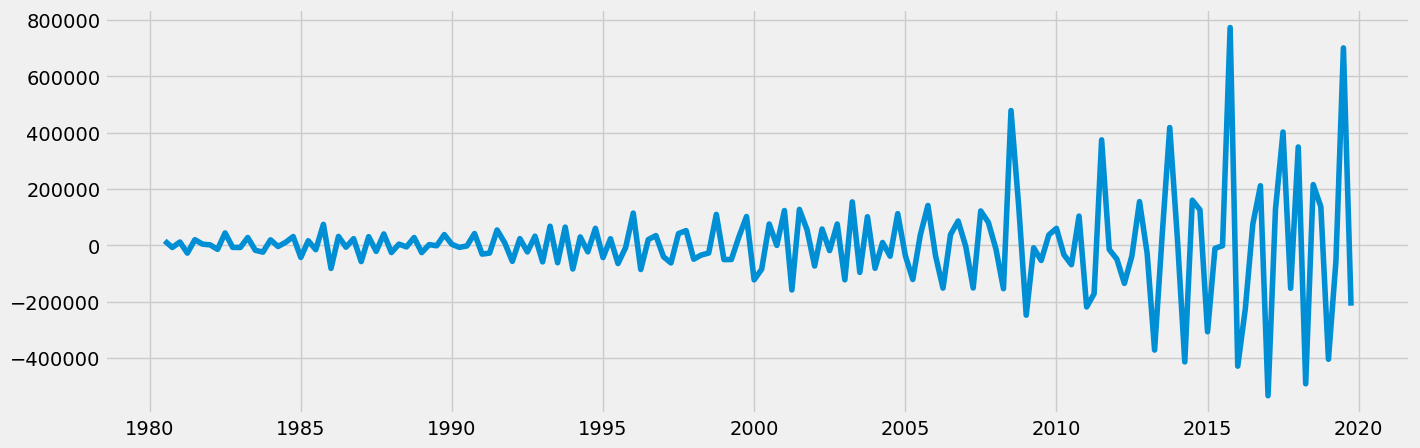

In [33]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [34]:
#Re-run Dickey-Fuller test
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.631458
p-value                          0.000113
Number of Lags Used              9.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


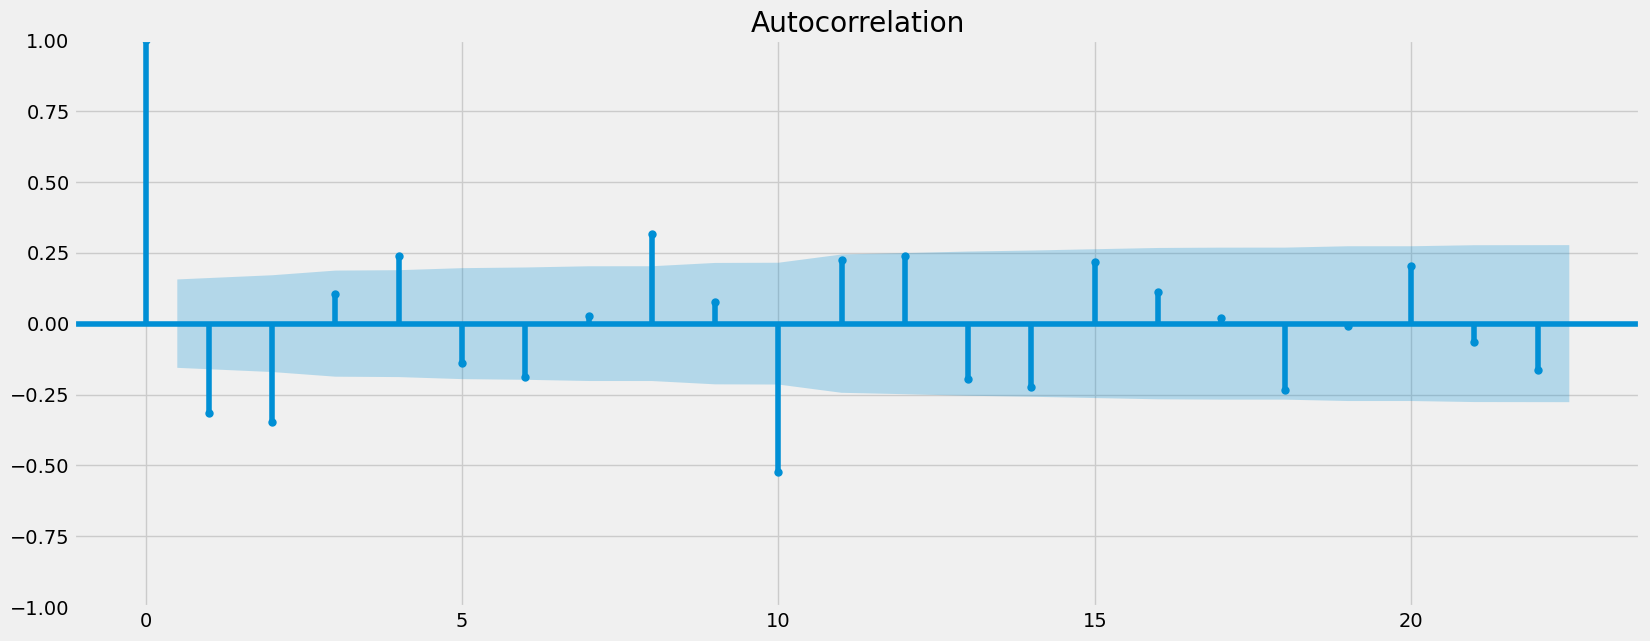

In [35]:
#Recheck Autocorrelation for data_diff2
plot_acf(data_diff2)
plt.show()

### The test statisic is smaller than the 5% confidence interval after the second round of differncing. Therefore, I can reject my null hypothesis of there being a unit root. This means that my data is non-stationary although it may somewhat weak because there are still some autocorrelations.

### While there are still a few lags above the blue confidence interval, there are less than 10 of them so the data is stationized.

## 7. Bonus Task

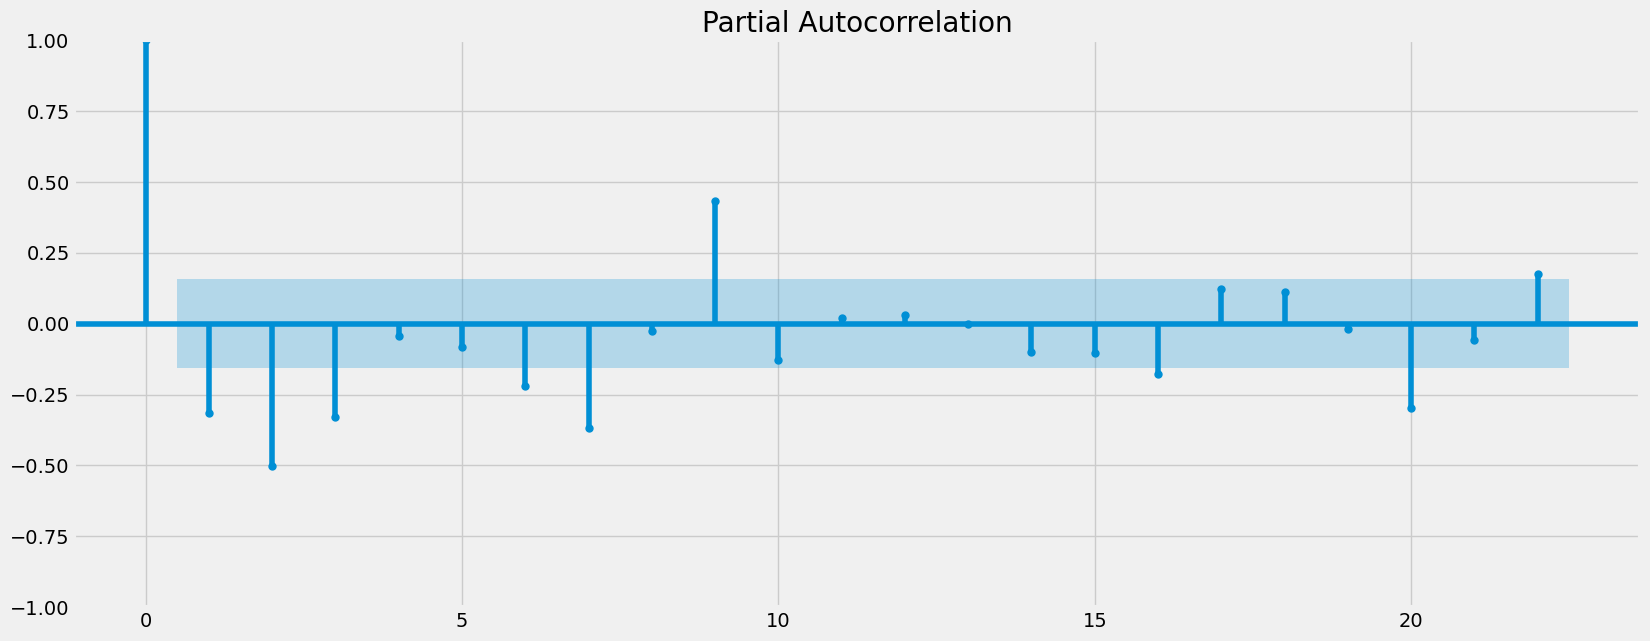

<Figure size 4500x4500 with 0 Axes>

In [36]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff2)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

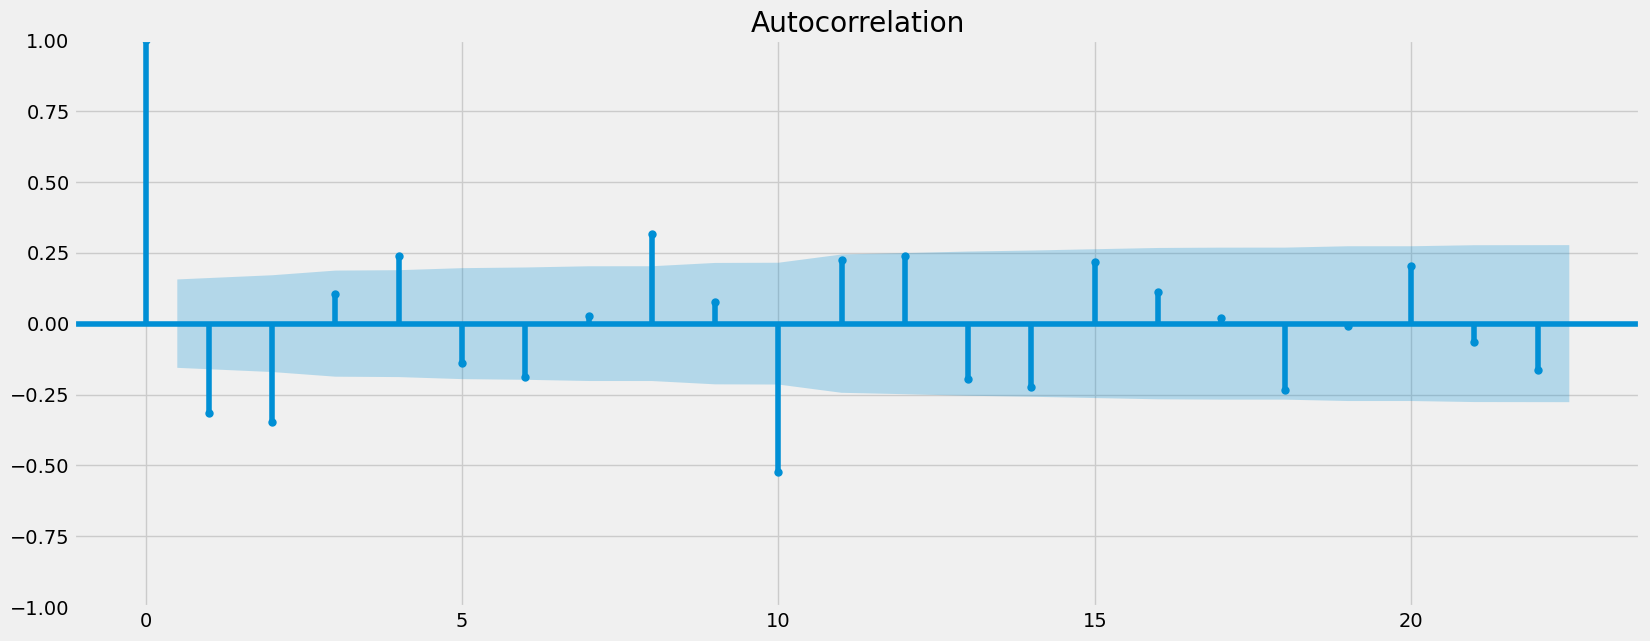

<Figure size 1500x500 with 0 Axes>

In [45]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff2)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

In [38]:
# Split the data
train = data_diff2['Value'][:821]
test = data_diff2['Value'][920:]   

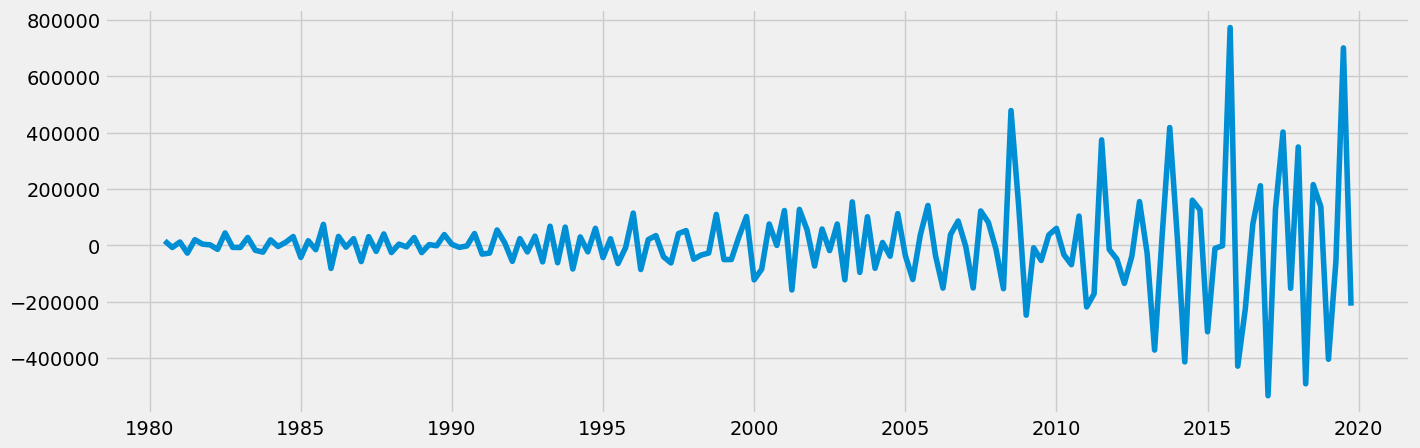

In [39]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [40]:
test.shape

(0,)

In [41]:
#Running and Fitting the Model
from statsmodels.tsa.api import ARIMA 

In [42]:
model = ARIMA(train, order=(5, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(41, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 41 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
lower_series = pd.Series(conf[:, 0], index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(conf[:, 1], index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  158
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2065.147
Date:                Thu, 21 Dec 2023   AIC                           4148.293
Time:                        12:42:38   BIC                           4175.800
Sample:                    07-01-1980   HQIC                          4159.465
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0508      0.099    -20.780      0.000      -2.244      -1.857
ar.L2         -2.4613      0.181    -13.574      0.000      -2.817      -2.106
ar.L3         -1.8787      0.216     -8.708      0.0

ValueError: too many values to unpack (expected 3)

In [43]:
#Iterating
model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(41, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  158
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -2076.154
Date:                Thu, 21 Dec 2023   AIC                           4162.308
Time:                        12:42:48   BIC                           4177.589
Sample:                    07-01-1980   HQIC                          4168.514
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6421      0.106     -6.084      0.000      -0.849      -0.435
ar.L2         -0.7021      0.076     -9.218      0.000      -0.851      -0.553
ar.L3         -0.3498      0.082     -4.242      0.0

ValueError: too many values to unpack (expected 3)

In [44]:
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(41, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  158
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2089.794
Date:                Thu, 21 Dec 2023   AIC                           4187.588
Time:                        12:42:49   BIC                           4199.813
Sample:                    07-01-1980   HQIC                          4192.553
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0965      0.141      0.686      0.493      -0.179       0.372
ma.L1         -1.8258      0.081    -22.524      0.000      -1.985      -1.667
ma.L2          0.8288      0.081     10.274      0.0

ValueError: too many values to unpack (expected 3)